# DPS the export of Google Earth Engine assets to MAAP

In [8]:
import ee
import numpy as np
import geopandas as gpd
import pandas as pd
import shapely
import glob
import os
from shapely.geometry import Polygon
from shapely.geometry import box
import matplotlib
import matplotlib.pyplot as plt
import rasterio as rio
import sys
sys.path.append('/projects/code/icesat2_boreal/lib')


In [2]:
ee.Authenticate()

Enter verification code:  4/1Adeu5BUzToi-_-5yzw34VFFxitazlLoCQ7whQQejFmuwHzspJuf3kw8BBkI



Successfully saved authorization token.


In [5]:
USER = 'montesano' #'nathanmthomas'
!mkdir -p /$HOME/shared-buckets/$USER/GEE/

In [6]:
!cp $HOME/.config/earthengine/credentials /$HOME/shared-buckets/$USER/GEE/

In [7]:
creds_file = f'https://maap-ops-workspace.s3.amazonaws.com/{USER}/GEE/credentials'

## Steps to commit, build DPS registration yaml, register DPS algorithm from yaml
### Commit with Tag for running
1) Add version name as a *tag_name* of `EXPORT_GEE_v1` or whatever is appropriate - both to this notebook and algorithm config yaml

2) follow git instructions (every time!!):  
 - git add changes  
 - git commit -m 'message'  
 - git tag -f `EXPORT_GEE_v1`    
 - git push  
 - git push origin -f `EXPORT_GEE_v1`  
        # --push to gitlab no longer needed --   
        # git push dps    
        # git push dps -f `EXPORT_GEE_v1`    

3) if it looks weird check git log to make sure tag is at same place as origin and dps

### Build DPS Registration yaml  
- use MAAP Register Algorithm tool  
- refer to `code/icesat2_boreal/dps/registered/do_export_gee_to_maap.yml` for existing template  
- update reg yaml repository url to the github url (gitlab no longer needed) 
- update `above_env.yml` and `build_command_main.sh` to include all pinned versions of packages - to ensure stability of env for this alg  

# Register algorithm for DPS

### Use Registration yaml: Register DPS algorithm
 - We need to register the DPS algorithm before proceeding to the chunks below...

In [ ]:
maap.register_algorithm_from_yaml_file("/projects/code/icesat2_boreal/dps/registered/do_export_gee_to_maap.yml").text

In [4]:
IDENTIFIER = 'SAR_S1_2018'

In [5]:
# MAAP algorithm version name
MAAP_VERSION = "EXPORT_GEE_v1"

# Process without DPS

In [135]:
import sys
sys.path.append('/projects/code/icesat2_boreal/lib')
import export_gee_to_maap
import ee_download
import zipfile

In [65]:
OUTDIR = '/projects/my-public-bucket/export_gee_to_maap_v2'

In [66]:
S3_PATH = f's3://maap-ops-workspace/shared/montesano/{os.path.basename(OUTDIR)}/'

!aws s3 rm --quiet --recursive $S3_PATH

In [67]:
!mkdir -p $OUTDIR

### [1]  Base command line approach

In [22]:
#!python /projects/code/icesat2_boreal/lib/export_gee_to_maap.py --tile_num 1 --dims 500 --asset_path 'projects/foreststructure/Circumboreal/S1_Composites_albers' --out_dir $OUTDIR

## Multiprocess GEE export of subtiles locally, loop over asset tiles

In [23]:
# def do_gee_download_by_subtile(index, TILELOC, fishnet_4326, asset_df, OUTDIR):
    
#     fails = []
    
#     try:
#         minx, miny, maxx, maxy = fishnet_4326.iloc[index].geometry.bounds

#         region = ee.Geometry.BBox(minx, miny, maxx, maxy)

#         # We want to submit to DPS this...
#         #print('Fetching..')
#         downloaded_image_fn = ee_download.download_image_by_asset_path(
#                                 asset_path = asset_df.iloc[TILELOC]['id'],
#                                 output_folder = OUTDIR,
#                                 region = region,
#                                 idx = str(index)
#                                 )
#         print(f'Index: {index} : {downloaded_image_fn}')

#         # Extract tif to zip
#         out_subdir = os.path.join(os.path.dirname(downloaded_image_fn) , os.path.splitext(downloaded_image_fn)[0])
#         with zipfile.ZipFile(downloaded_image_fn, 'r') as zip_ref:
#             zip_ref.extractall(out_subdir)
#         os.remove(downloaded_image_fn)
            
#     except Exception as e:
#         raise e
#         fails.append(fishnet_4326.iloc[index])
        
#     return fails
        
def find_index_to_process(index, OUTDIR_TILE, DEBUG=False):
    '''Get a list of subtile stacks of a GEE asset tile that remain to be processed. Prevents re-doing completing tiles.
    Note: 6 bands (tifs) should be finished for each SAR stack
    '''
    
    LIST_INDEX_TO_PROCESS = []
    # Ideally use s3.glob here, but s3fs not importing correctly
    num_exported_tifs_subtile = len(glob.glob(OUTDIR_TILE +f'/*-subtile{index:06}/*.tif'))
    #num_exported_tifs_subtile = len(s3.glob(OUTDIR_TILE +f'/*-subtile{index:06}/*.tif'))
    
    if DEBUG:
        print(f'{num_exported_tifs_subtile} subtiles for tile {index}')

    # This prevents re-doing perfectly good and complete exports
    # Only add to 'todo' list to export if an existing export sutile dir was interrupted (has less than the expected 6 tifs)
    if num_exported_tifs_subtile < 6:
        if DEBUG:
            print(f'Returning subtile {index} for processing...')
        return index
    else:
        if DEBUG:
            print(f'{index} done.')
        else:
            pass
        return None

In [24]:
from multiprocessing import Pool
from functools import partial

In [25]:
# For some reason this is needed to get s3fs to work in ExtractUtils
# this upgrades to 0.3.4 even though we already specify this version in requirements_main...
##!pip install s3fs --upgrade

In [26]:
import s3fs
s3 = s3fs.S3FileSystem(anon=True)

### Test of multiprocessing: buiding list of subtiles to process
this needs a fishnet_4326

In [29]:
%%time
if False:
    OUTDIR_TILE = '/projects/my-public-bucket/export_gee_to_maap_v2/asset_index_001'
    full_index_list = [index for index, row in fishnet_4326.iterrows()]
    print(f'{len(full_index_list)}')
    if True:
        with Pool(processes=30) as pool:
            LIST_INDEX_TO_PROCESS = pool.map(partial(find_index_to_process, OUTDIR_TILE=OUTDIR_TILE, DEBUG=True), full_index_list[:1])
    else:
        LIST_INDEX_TO_PROCESS = [find_index_to_process(index, OUTDIR_TILE=OUTDIR_TILE) for index in full_index_list[-50:]]

    LIST_INDEX_TO_PROCESS = [index for index in LIST_INDEX_TO_PROCESS if index is not None]
    len(LIST_INDEX_TO_PROCESS)
    
    LIST_INDEX_TO_PROCESS = [index for index in LIST_INDEX_TO_PROCESS if index is not None]
    LIST_INDEX_TO_PROCESS

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.63 µs


# Local loop per GEE asset tile
multi-processes the thousands of subtiles per asset tile  
delivers to `asset_tile_<TILE_ILOC>/s1_vv_vh_gamma_2018_pwr_tile<TILE_ILOC>-subtile<zero-padded subtile index number>/*.tif`

This provides a strategy for DPS.  
 - a DPS batch could consist of the downloading and unzipping of the thousands (~3000 - 28000) of subtiles for a batch associated with a single GEE asset tile

In [12]:
#do_gee_download_by_subtile.do_gee_download_by_subtile(index, TILELOC=TILELOC, fishnet=fishnet, asset_df=asset_df, OUTDIR=OUTDIR_TILE)

### Make a geodataframe of asset footprints

In [30]:
# Get the asset data frame that bounds the tiles of the asset in this image collection
asset_df = do_gee_download_by_subtile.get_gee_assets('projects/foreststructure/Circumboreal/S1_Composites_albers')

asset_properties_df = pd.DataFrame(asset_df.properties.to_list()).reset_index()
asset_properties_geom_data = [shapely.geometry.Polygon(asset_df.properties[x]['system:footprint']['coordinates']) for x in list(range(0, len(asset_df.properties.to_list())))]
asset_properties_gdf = gpd.GeoDataFrame(asset_properties_df, crs=4326, geometry=gpd.GeoSeries(asset_properties_geom_data)).drop(['system:footprint'], axis=1)

<Axes: >

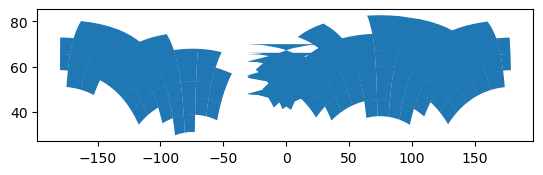

In [31]:
asset_properties_gdf.plot()

In [32]:
#fishnet_4326.explore()

In [33]:
# Notice the AGG_TILE_NUM doesnt match index locs, which is ok
agg_tile_num_list =  asset_properties_gdf.AGG_TILE_NUM.to_list()
keys = asset_properties_gdf.index.to_list()
print(dict(zip(keys, agg_tile_num_list)))

{0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 101, 11: 102, 12: 103, 13: 104, 14: 105, 15: 106, 16: 107, 17: 108, 18: 109, 19: 11, 20: 110, 21: 12, 22: 13, 23: 14, 24: 15, 25: 16, 26: 17, 27: 18, 28: 19, 29: 20, 30: 21, 31: 22, 32: 23, 33: 24, 34: 25, 35: 26, 36: 27, 37: 28, 38: 29, 39: 30, 40: 31, 41: 32, 42: 33, 43: 34, 44: 35, 45: 36, 46: 37, 47: 38, 48: 39, 49: 40, 50: 41, 51: 42, 52: 43, 53: 44, 54: 45, 55: 46, 56: 47, 57: 48, 58: 49, 59: 50, 60: 51, 61: 52, 62: 53, 63: 54, 64: 55, 65: 56, 66: 57, 67: 58, 68: 59, 69: 60, 70: 61, 71: 62, 72: 63, 73: 64, 74: 65, 75: 66, 76: 67, 77: 68, 78: 69, 79: 70, 80: 71, 81: 72, 82: 73, 83: 74, 84: 75, 85: 76, 86: 77, 87: 78, 88: 79, 89: 80, 90: 81, 91: 82, 92: 83, 93: 84, 94: 85, 95: 86, 96: 87, 97: 88, 98: 89, 99: 90, 100: 91, 101: 92, 102: 95, 103: 96, 104: 97, 105: 98, 106: 99}


In [ ]:
region  = fishnet_df.iloc[0]
minx, miny, maxx, maxy = region.geometry.bounds
region_ee = ee.Geometry.BBox(minx, miny, maxx, maxy)
region_ee

In [ ]:
# Pulled out from loop below for testing
do_gee_download_by_subtile.do_gee_download_by_subtile(index, TILELOC=TILELOC, fishnet=fishnet_df, asset_df=asset_df, OUTDIR=OUTDIR_TILE)

In [196]:
import do_gee_download_by_subtile
import export_gee_to_maap
import ee_download

import importlib
importlib.reload(do_gee_download_by_subtile)
importlib.reload(export_gee_to_maap)
importlib.reload(ee_download)

<module 'ee_download' from '/projects/code/icesat2_boreal/lib/ee_download.py'>

In [197]:
OUTDIR

'/projects/my-public-bucket/export_gee_to_maap_v2'

In [198]:
%%time

ASSET_PATH = 'projects/foreststructure/Circumboreal/S1_Composites_albers'

# Append indiv asset tile gdf to this list to concat into a final gdf of all subtiles from all asset tiles
fishnet_4326_list = []

#for TILELOC in asset_df.index.to_list():
for TILELOC in [3]:
    
    #### IF DPSing by subtile, you need TILELOC and ASSET_PATH to get gee asset_df and the tile fishnet even before you call 'do_gee_download_by_subtile'
    
    # We need this asset_df to know how to loop over asset tiles - but the script also needs it during processing and to use it to build a fishnet_df 
    asset_df = do_gee_download_by_subtile.get_gee_assets(ASSET_PATH)
    ASSET_TILE_NAME = os.path.basename(asset_df.id.to_list()[TILELOC])
    
    # --- THIS IS NOW MADE IN do_gee_download_by_subtile
    # Make asset tile subdir
    OUTDIR_TILE = os.path.join(OUTDIR, ASSET_TILE_NAME)
    if not os.path.exists(OUTDIR_TILE):
        os.makedirs(OUTDIR_TILE)
    
    #print(f'GEE Asset tile loc position # {TILELOC} in subdir: {OUTDIR_TILE}')
    print(f'GEE Asset tile loc # {TILELOC} will go an asset tile dir: {ASSET_TILE_NAME}')
    
    fishnet_df = do_gee_download_by_subtile.create_fishnet(asset_df, TILELOC, 500)
    fishnet_df['subtile'] = fishnet_df.index
    fishnet_df['tile'] = TILELOC
    
    # iterate over fishnet and import GEE image
    fishnet_4326 = fishnet_df.to_crs("EPSG:4326")
    
    ## This will multprocess the glob for unfinished subtiles
    # Get full index list
    LIST_INDEX_TO_PROCESS = [index for index, row in fishnet_4326.iterrows()]
    
    if False:
        # Only needed to eliminate replication of subtile processing during local re-runs across an asset tile
        with Pool(processes=25) as pool:
            LIST_INDEX_TO_PROCESS = pool.map(partial(find_index_to_process, OUTDIR_TILE=OUTDIR_TILE), LIST_INDEX_TO_PROCESS)

        # Get rid of Nones in list
        LIST_INDEX_TO_PROCESS = [index for index in LIST_INDEX_TO_PROCESS if index is not None]
    
    print(f'\t{len(LIST_INDEX_TO_PROCESS)} subtiles to process')
    
    #
    # Process the subtile download for this GEE asset tile
    # note: both cause transport endpoint disconnects... need to DPS
    # replace this with maap.submitJob()
    # 
    if True:
        # Loop
        #for index in LIST_INDEX_TO_PROCESS: #<------------CHANGE THIS AFTER TESTS
        LIST_FOR_TEST = [LIST_INDEX_TO_PROCESS[x] for x in list(range(3,7))+list(range(55,59)) ]
        for index in LIST_FOR_TEST:
            args = ''
            if False:
                # Test of imported function
                #do_gee_download_by_subtile.do_gee_download_by_subtile(index, TILELOC=TILELOC, fishnet=fishnet_df, asset_df=asset_df, OUTDIR=OUTDIR_TILE)
                do_gee_download_by_subtile.do_gee_download_by_subtile(SUBTILE_LOC=index, TILELOC=TILELOC, ASSET_PATH=ASSET_PATH, OUTDIR=OUTDIR_TILE)
            else:
                # Test of cmd line main function
                args += f'--subtile_loc {index} '
                args += f'--tile_loc {TILELOC} '
                args += f'--asset_path {ASSET_PATH} '
                args += f'--out_dir {OUTDIR_TILE} '
                !python /projects/code/icesat2_boreal/lib/do_gee_download_by_subtile.py $args
    else:
        # Multiprocess
        with Pool(processes=25) as pool:
            fails = pool.map(partial(do_gee_download_by_subtile.do_gee_download_by_subtile, TILELOC=TILELOC, fishnet=fishnet_df, asset_df=asset_df, OUTDIR=OUTDIR_TILE ), LIST_INDEX_TO_PROCESS)

    fishnet_4326_list.append(fishnet_4326)

final_fishnet_gdf = pd.concat(fishnet_4326_list)
final_fishnet_gdf.to_file(os.path.join(OUTDIR, 'final_fishnet.gpkg'), driver='GPKG')

GEE Asset tile loc # 3 will go an asset tile dir: s1_vv_vh_gamma_2018_pwr_tile04
	asset id = projects/foreststructure/Circumboreal/S1_Composites_albers/s1_vv_vh_gamma_2018_pwr_tile04
	rows = 27478 cols =  27585
	3080 subtiles to process

	Subtile 3 for tile loc 3 to subdir: /projects/my-public-bucket/export_gee_to_maap_v2/s1_vv_vh_gamma_2018_pwr_tile04/s1_vv_vh_gamma_2018_pwr_tile04
	asset id = projects/foreststructure/Circumboreal/S1_Composites_albers/s1_vv_vh_gamma_2018_pwr_tile04
	rows = 27478 cols =  27585
	SUBTILE_LOC: 3 : extracted tifs to /projects/my-public-bucket/export_gee_to_maap_v2/s1_vv_vh_gamma_2018_pwr_tile04/s1_vv_vh_gamma_2018_pwr_tile04-subtile000003

	Subtile 4 for tile loc 3 to subdir: /projects/my-public-bucket/export_gee_to_maap_v2/s1_vv_vh_gamma_2018_pwr_tile04/s1_vv_vh_gamma_2018_pwr_tile04
	asset id = projects/foreststructure/Circumboreal/S1_Composites_albers/s1_vv_vh_gamma_2018_pwr_tile04
	rows = 27478 cols =  27585
	SUBTILE_LOC: 4 : extracted tifs to /project

In [195]:
S3_PATH = f's3://maap-ops-workspace/shared/montesano/{os.path.basename(OUTDIR)}/'
!aws s3 rm --quiet --recursive $S3_PATH
!mkdir -p $OUTDIR

# TODO - set this up according to DPS strategy.. 

In [ ]:
%%time
submit_results_df_list = []
len_input_list = len(DPS_INPUT_TILE_NUM_LIST)
print(f"# of input tiles for DPS: {len_input_list}")

for i, INPUT_TILE_NUM in enumerate(list(range(0,52))):

    DPS_num = i+1
    IDENTIFIER = IDENTIFIER 
    ALGO_ID = "do_gee_download_subtile_v1"
    USER = 'montesano'
    WORKER_TYPE = 'maap-dps-worker-16gb'
    
    in_param_dict = {
                         'tile_num': ,
                         'dims': 500,
                         'asset_path': 'projects/foreststructure/Circumboreal/S1_Composites_albers'
                        
        }
        
    submit_result = maap.submitJob(
                                    identifier=IDENTIFIER,
                                    algo_id=ALGO_ID,
                                    version=MAAP_VERSION, # "HLS_stack_2023_v1"
                                    username=USER,
                                    queue=WORKER_TYPE,
                                    # Args that match yaml
                                    **in_param_dict
        )
    
    # Build a dataframe of submission details
    submit_result_df = pd.DataFrame( 
        {
                'dps_num':[DPS_num],
                'tile_num':[INPUT_TILE_NUM],
                'submit_time':[datetime.datetime.now()],
                'dbs_job_hour': [datetime.datetime.now().hour],
                'algo_id': [ALGO_ID],
                'user': [USER],
                'worker_type': [WORKER_TYPE],
                'job_id': [submit_result.id],
                'submit_status': [submit_result.retrieve_status()],
            
        } 
    )
    
    # Append to a list of data frames of submission results
    submit_results_df_list.append(submit_result_df)
    
    if DPS_num in [1, 5, 10, 50, 100, 250, 500, 750, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 7000, 9000, 11000, 13000, 15000, 17000, 19000, 21000, 24000, len_input_list]:
        print(f"DPS run #: {DPS_num}\t| tile num: {INPUT_TILE_NUM}\t| submit status: {submit_result.retrieve_status()}\t| job id: {submit_result.id}") 
        
# Build a final submission results df and save
submit_results_df = pd.concat(submit_results_df_list)
submit_results_df['run_name'] = RUN_NAME
nowtime = pd.Timestamp.now().strftime('%Y%m%d%H%M')
print(f"Current time:\t{nowtime}")
submit_results_df.to_csv(f'/projects/my-public-bucket/dps_submission_results/DPS_{ALGO_ID}_{RUN_NAME}_submission_results_{len_input_list}_{nowtime}.csv')
submit_results_df.info()